In [13]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import sqlite3
import pandas as pd
from lsst.sims.featureScheduler.utils import standard_goals
import healpy as hp
from lsst.sims.utils import hpid2RaDec
from scipy.stats import binned_statistic
from lsst.utils import getPackageDir
import os
import lsst.sims.featureScheduler.utils as utils


In [32]:
filename = '/Users/yoachim/gitRepos/sims_featureScheduler_runs_1.3/footprints/big_sky_dust_v1.3_10yrs.db'
#filename = '../baseline/baseline_v1.4_10yrs.db'
conn = sqlite3.connect(filename)
#df = pd.read_sql('select observationStartLST,fieldRA from SummaryAllProps where note not like "DD%" ;', conn)
df = pd.read_sql('select observationStartLST,fieldRA from SummaryAllProps;', conn)

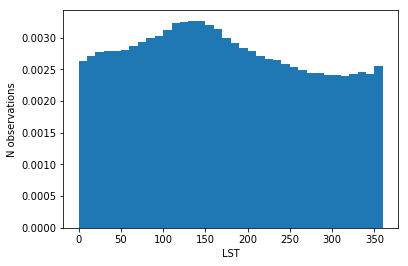

In [33]:
bins = np.arange(0,361, 10)
ack = plt.hist(df['observationStartLST'], bins=bins, normed=True)
plt.xlabel('LST')
plt.ylabel('N observations')

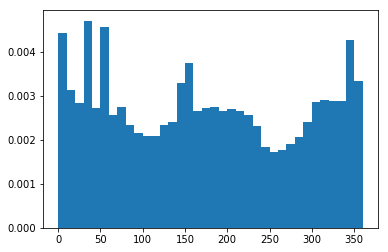

In [34]:
ack_ra =  plt.hist(df['fieldRA'], bins=bins, normed=True)

In [25]:
def big_sky_dust(nside=32, weights={'u': [0.31, 0.15, False], 'g': [0.44, 0.15],
                 'r': [1., 0.3], 'i': [1., 0.3], 'z': [0.9, 0.3],
                 'y': [0.9, 0.3, False]}, dust_limit=0.19):
    """
    Based on the Olsen et al Cadence White Paper
    """

    ebvDataDir = getPackageDir('sims_maps')
    filename = 'DustMaps/dust_nside_%i.npz' % nside
    dustmap = np.load(os.path.join(ebvDataDir, filename))['ebvMap']

    # wfd covers -72.25 < dec < 12.4. Avoid galactic plane |b| > 15 deg
    wfd_north = np.radians(12.4)
    wfd_south = np.radians(-72.25)
    full_north = np.radians(30.)

    ra, dec = utils.ra_dec_hp_map(nside=nside)
    total_map = np.zeros(ra.size)

    # let's make a first pass here

    total_map[np.where(dec < full_north)] = 1e-6
    total_map[np.where((dec > wfd_south) &
                       (dec < wfd_north) &
                       (dustmap < dust_limit))] = 1.

    # Now let's break it down by filter
    result = {}

    for key in weights:
        result[key] = total_map + 0.
        result[key][np.where(result[key] == 1)] = weights[key][0]
        result[key][np.where(result[key] == 1e-6)] = weights[key][1]
        if len(weights[key]) == 3:
            result[key][np.where(dec > wfd_north)] = 0.

    return result

In [26]:
nside = 32
sg = big_sky_dust(nside=nside)
total_requested = sg['r']*0
for key in sg:
    total_requested += sg[key]

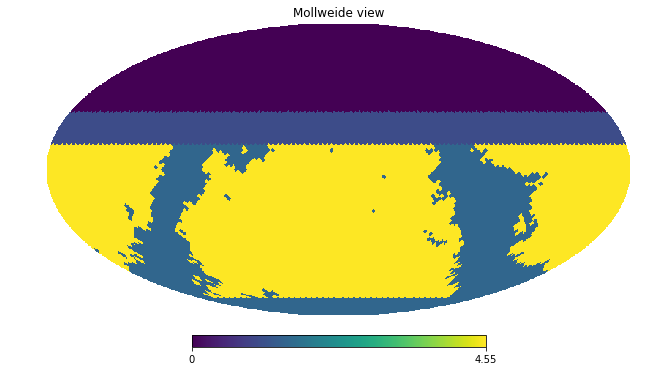

In [27]:
hp.mollview(total_requested)

In [28]:
ra,dec = hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))

In [35]:
binned_requested, be, bn = binned_statistic(ra, total_requested, statistic=np.sum, bins=bins)

br = binned_requested/(np.sum(binned_requested)*(be[1]-be[0]))

<Container object of 36 artists>

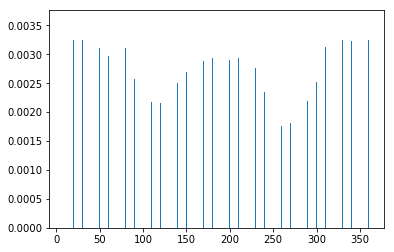

In [36]:
plt.bar(be[1:], br)

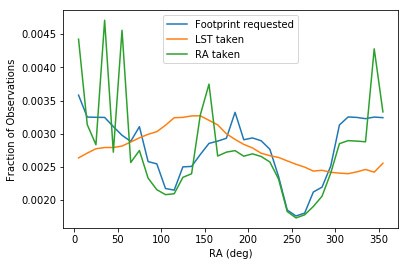

In [37]:
bc = (be[0:-1]+be[1:])/2.
plt.plot(bc, br, label='Footprint requested')
plt.plot(bc, ack[0], label='LST taken')
plt.plot(bc, ack_ra[0], label='RA taken')
plt.xlabel('RA (deg)')
plt.ylabel('Fraction of Observations')
plt.legend()

plt.savefig('oversub.pdf')
# Blue line above means we are over-subscribed
# Blue line below means we are under-subscribed

# Spikes in blue result of HEALpix distribution in RA not being random

# Note that adding DDFs makes this worse if they are in the popular extra-galactic area